In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3
env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [2]:
import os
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
structures = pd.read_pickle("datasets/structures_defects.pickle.gzip")

In [4]:
# TODO(inner perfectionist) eval is unsecure
defects = pd.read_csv(
  "datasets/dichalcogenides_innopolis_202105/descriptors.csv", index_col="_id",
  converters={"cell": eval, "defects": eval})

In [5]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.utils.preprocessing import StandardScaler
from megnet.callbacks import ModelCheckpointMAE
from pymatgen.core import Lattice, Structure, Molecule

import tensorflow as tf
import numpy as np

In [6]:
import wandb
from wandb.keras import WandbCallback

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# TODO(kazeevn) pass structure as the global state
train, test = train_test_split(structures, test_size=0.25, random_state=42)

In [9]:
wandb.init(project='ai4material_design', entity='kazeev')

wandb: Currently logged in as: kazeev (use `wandb login --relogin` to force relogin)


In [10]:
config = wandb.config
config.target = "homo"

In [11]:
from typing import Union, List, Dict
from megnet.data.graph import StructureGraphFixedRadius
from pymatgen.analysis.local_env import NearNeighbors
from megnet.data.graph import Converter
class ZAwareStrucutreGraph(StructureGraphFixedRadius):
    def __init__(
        self,
        nn_strategy: Union[str, NearNeighbors] = "MinimumDistanceNNAll",
        atom_converter: Converter = None,
        bond_converter: Converter = None,
        cutoff: float = 5.0,
    ):
      raise NotImplemented("Doesn't work due to difficult estate planning")
      self.cutoff = cutoff
      super().__init__(
              nn_strategy=nn_strategy, atom_converter=atom_converter, bond_converter=bond_converter, cutoff=self.cutoff
      )
        
      @staticmethod
      def get_atom_features(structure):
        return [[i.species.Z, i.coords[2]] for i in structure.sites]

In [12]:
nfeat_edge = 10
gc = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 15, nfeat_edge), 0.5),
                  cutoff=15)
model = MEGNetModel(nfeat_edge=nfeat_edge, nfeat_global=2, graph_converter=gc, npass=2)

In [13]:
scaler = StandardScaler.from_training_data(train.defect_representation,
                                           train[config.target], is_intensive=True)
model.target_scaler = scaler

In [14]:
model.train(train.defect_representation, train[config.target],
            validation_structures=test.defect_representation,
            validation_targets=test[config.target],
            callbacks=[WandbCallback()],
            epochs=10000, verbose=1, patience=1000)

Epoch 1/10000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/set2set_atom/Reshape_9:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/set2set_atom/Reshape_8:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/model/set2set_atom/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/set2set_bond/Reshape_9:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/set2set_bond/Reshape_8:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/model/set2set_bond/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of m

21/21 [==============================] - 21s 173ms/step - loss: 1.2526


INFO:megnet.callbacks:
Epoch 00001: val_mae improved from inf to 0.08668, saving model to callback/val_mae_00001_0.086678.hdf5


Epoch 2/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.1060


INFO:megnet.callbacks:
Epoch 00002: val_mae improved from 0.08668 to 0.07294, saving model to callback/val_mae_00002_0.072944.hdf5


Epoch 3/10000
21/21 [==============================] - 4s 176ms/step - loss: 0.0971
Epoch 4/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0982
Epoch 5/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0953
Epoch 6/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0934


INFO:megnet.callbacks:
Epoch 00006: val_mae improved from 0.07294 to 0.07179, saving model to callback/val_mae_00006_0.071786.hdf5


Epoch 7/10000
21/21 [==============================] - 4s 178ms/step - loss: 0.0905
Epoch 8/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0904
Epoch 9/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0750


INFO:megnet.callbacks:
Epoch 00009: val_mae improved from 0.07179 to 0.06844, saving model to callback/val_mae_00009_0.068438.hdf5


Epoch 10/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0713
Epoch 11/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0753
Epoch 12/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0653
Epoch 13/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0672


INFO:megnet.callbacks:
Epoch 00013: val_mae improved from 0.06844 to 0.06765, saving model to callback/val_mae_00013_0.067654.hdf5


Epoch 14/10000
21/21 [==============================] - 5s 256ms/step - loss: 0.0649


INFO:megnet.callbacks:
Epoch 00014: val_mae improved from 0.06765 to 0.06758, saving model to callback/val_mae_00014_0.067579.hdf5


Epoch 15/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0576


INFO:megnet.callbacks:
Epoch 00015: val_mae improved from 0.06758 to 0.06726, saving model to callback/val_mae_00015_0.067257.hdf5


Epoch 16/10000
21/21 [==============================] - 3s 167ms/step - loss: 0.0698
Epoch 17/10000
21/21 [==============================] - 3s 150ms/step - loss: 0.0611


INFO:megnet.callbacks:
Epoch 00017: val_mae improved from 0.06726 to 0.06453, saving model to callback/val_mae_00017_0.064530.hdf5


Epoch 18/10000
21/21 [==============================] - 6s 276ms/step - loss: 0.0568
Epoch 19/10000
21/21 [==============================] - 5s 204ms/step - loss: 0.0587


INFO:megnet.callbacks:
Epoch 00019: val_mae improved from 0.06453 to 0.06341, saving model to callback/val_mae_00019_0.063408.hdf5


Epoch 20/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0565
Epoch 21/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0572
Epoch 22/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0551


INFO:megnet.callbacks:
Epoch 00022: val_mae improved from 0.06341 to 0.06089, saving model to callback/val_mae_00022_0.060888.hdf5


Epoch 23/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0555


INFO:megnet.callbacks:
Epoch 00023: val_mae improved from 0.06089 to 0.05992, saving model to callback/val_mae_00023_0.059925.hdf5


Epoch 24/10000
21/21 [==============================] - 3s 156ms/step - loss: 0.0574
Epoch 25/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0528
Epoch 26/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0521
Epoch 27/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0560 2


INFO:megnet.callbacks:
Epoch 00027: val_mae improved from 0.05992 to 0.05954, saving model to callback/val_mae_00027_0.059545.hdf5


Epoch 28/10000
21/21 [==============================] - 3s 167ms/step - loss: 0.0477
Epoch 29/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0490
Epoch 30/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0463
Epoch 31/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0491
Epoch 32/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0543


INFO:megnet.callbacks:
Epoch 00032: val_mae improved from 0.05954 to 0.05659, saving model to callback/val_mae_00032_0.056592.hdf5


Epoch 33/10000
21/21 [==============================] - 3s 146ms/step - loss: 0.0453
Epoch 34/10000
21/21 [==============================] - 3s 155ms/step - loss: 0.0505
Epoch 35/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0507
Epoch 36/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0479
Epoch 37/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0511
Epoch 38/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0467
Epoch 39/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0490
Epoch 40/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0547
Epoch 41/10000
21/21 [==============================] - 3s 168ms/step - loss: 0.0454
Epoch 42/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0479
Epoch 43/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0465
Epoch 44/10000
21/21 [==============================] - 3s 161ms/

INFO:megnet.callbacks:
Epoch 00044: val_mae improved from 0.05659 to 0.05637, saving model to callback/val_mae_00044_0.056371.hdf5


Epoch 45/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0418


INFO:megnet.callbacks:
Epoch 00045: val_mae improved from 0.05637 to 0.05585, saving model to callback/val_mae_00045_0.055849.hdf5


Epoch 46/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0462
Epoch 47/10000
21/21 [==============================] - 3s 154ms/step - loss: 0.0431
Epoch 48/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0407
Epoch 49/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0423


INFO:megnet.callbacks:
Epoch 00049: val_mae improved from 0.05585 to 0.05296, saving model to callback/val_mae_00049_0.052956.hdf5


Epoch 50/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0416
Epoch 51/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0451


INFO:megnet.callbacks:
Epoch 00051: val_mae improved from 0.05296 to 0.05279, saving model to callback/val_mae_00051_0.052790.hdf5


Epoch 52/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0419


INFO:megnet.callbacks:
Epoch 00052: val_mae improved from 0.05279 to 0.05155, saving model to callback/val_mae_00052_0.051546.hdf5


Epoch 53/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0378
Epoch 54/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0404
Epoch 55/10000
21/21 [==============================] - 4s 180ms/step - loss: 0.0410
Epoch 56/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0416
Epoch 57/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0398


INFO:megnet.callbacks:
Epoch 00057: val_mae improved from 0.05155 to 0.05010, saving model to callback/val_mae_00057_0.050097.hdf5


Epoch 58/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0440
Epoch 59/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0388
Epoch 60/10000
21/21 [==============================] - 3s 158ms/step - loss: 0.0410


INFO:megnet.callbacks:
Epoch 00060: val_mae improved from 0.05010 to 0.04981, saving model to callback/val_mae_00060_0.049809.hdf5


Epoch 61/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0382
Epoch 62/10000
21/21 [==============================] - 3s 139ms/step - loss: 0.0368


INFO:megnet.callbacks:
Epoch 00062: val_mae improved from 0.04981 to 0.04975, saving model to callback/val_mae_00062_0.049754.hdf5


Epoch 63/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0340


INFO:megnet.callbacks:
Epoch 00063: val_mae improved from 0.04975 to 0.04903, saving model to callback/val_mae_00063_0.049034.hdf5


Epoch 64/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0366
Epoch 65/10000
21/21 [==============================] - 4s 174ms/step - loss: 0.0382
Epoch 66/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0359
Epoch 67/10000
21/21 [==============================] - 4s 180ms/step - loss: 0.0334
Epoch 68/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0362
Epoch 69/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0346
Epoch 70/10000
21/21 [==============================] - 3s 146ms/step - loss: 0.0347
Epoch 71/10000
21/21 [==============================] - 3s 140ms/step - loss: 0.0343


INFO:megnet.callbacks:
Epoch 00071: val_mae improved from 0.04903 to 0.04762, saving model to callback/val_mae_00071_0.047618.hdf5


Epoch 72/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0340
Epoch 73/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0337
Epoch 74/10000
21/21 [==============================] - 4s 181ms/step - loss: 0.0325
Epoch 75/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0310
Epoch 76/10000
21/21 [==============================] - 3s 156ms/step - loss: 0.0328
Epoch 77/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0358
Epoch 78/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0310
Epoch 79/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0324
Epoch 80/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0321


INFO:megnet.callbacks:
Epoch 00080: val_mae improved from 0.04762 to 0.04683, saving model to callback/val_mae_00080_0.046831.hdf5


Epoch 81/10000
21/21 [==============================] - 4s 183ms/step - loss: 0.0352
Epoch 82/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0318
Epoch 83/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0311
Epoch 84/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0289


INFO:megnet.callbacks:
Epoch 00084: val_mae improved from 0.04683 to 0.04518, saving model to callback/val_mae_00084_0.045180.hdf5


Epoch 85/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0278
Epoch 86/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0310
Epoch 87/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0306


INFO:megnet.callbacks:
Epoch 00087: val_mae improved from 0.04518 to 0.04351, saving model to callback/val_mae_00087_0.043513.hdf5


Epoch 88/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0286
Epoch 89/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0292


INFO:megnet.callbacks:
Epoch 00089: val_mae improved from 0.04351 to 0.04305, saving model to callback/val_mae_00089_0.043052.hdf5


Epoch 90/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0273
Epoch 91/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0299


INFO:megnet.callbacks:
Epoch 00091: val_mae improved from 0.04305 to 0.04275, saving model to callback/val_mae_00091_0.042750.hdf5


Epoch 92/10000
21/21 [==============================] - 4s 175ms/step - loss: 0.0275
Epoch 93/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0261
Epoch 94/10000
21/21 [==============================] - 4s 174ms/step - loss: 0.0263


INFO:megnet.callbacks:
Epoch 00094: val_mae improved from 0.04275 to 0.04267, saving model to callback/val_mae_00094_0.042670.hdf5


Epoch 95/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0262
Epoch 96/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0278
Epoch 97/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0265
Epoch 98/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0292
Epoch 99/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0258
Epoch 100/10000
21/21 [==============================] - 3s 167ms/step - loss: 0.0248
Epoch 101/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0250
Epoch 102/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0235


INFO:megnet.callbacks:
Epoch 00102: val_mae improved from 0.04267 to 0.04052, saving model to callback/val_mae_00102_0.040522.hdf5


Epoch 103/10000
21/21 [==============================] - 3s 155ms/step - loss: 0.0229


INFO:megnet.callbacks:
Epoch 00103: val_mae improved from 0.04052 to 0.03950, saving model to callback/val_mae_00103_0.039499.hdf5


Epoch 104/10000
21/21 [==============================] - 3s 150ms/step - loss: 0.0212
Epoch 105/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0272
Epoch 106/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0230
Epoch 107/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0242
Epoch 108/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0247
Epoch 109/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0226


INFO:megnet.callbacks:
Epoch 00109: val_mae improved from 0.03950 to 0.03944, saving model to callback/val_mae_00109_0.039441.hdf5


Epoch 110/10000
21/21 [==============================] - 3s 147ms/step - loss: 0.0206
Epoch 111/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0211
Epoch 112/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0220
Epoch 113/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0222


INFO:megnet.callbacks:
Epoch 00113: val_mae improved from 0.03944 to 0.03783, saving model to callback/val_mae_00113_0.037830.hdf5


Epoch 114/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0225
Epoch 115/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0188


INFO:megnet.callbacks:
Epoch 00115: val_mae improved from 0.03783 to 0.03741, saving model to callback/val_mae_00115_0.037413.hdf5


Epoch 116/10000
21/21 [==============================] - 4s 161ms/step - loss: 0.0193
Epoch 117/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0208
Epoch 118/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0222
Epoch 119/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0232


INFO:megnet.callbacks:
Epoch 00119: val_mae improved from 0.03741 to 0.03698, saving model to callback/val_mae_00119_0.036976.hdf5


Epoch 120/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0208
Epoch 121/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0235
Epoch 122/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0219
Epoch 123/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0187
Epoch 124/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0201
Epoch 125/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0182
Epoch 126/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0202
Epoch 127/10000
21/21 [==============================] - 3s 157ms/step - loss: 0.0223


INFO:megnet.callbacks:
Epoch 00127: val_mae improved from 0.03698 to 0.03697, saving model to callback/val_mae_00127_0.036968.hdf5


Epoch 128/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0197
Epoch 129/10000
21/21 [==============================] - 3s 146ms/step - loss: 0.0192
Epoch 130/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0198


INFO:megnet.callbacks:
Epoch 00130: val_mae improved from 0.03697 to 0.03600, saving model to callback/val_mae_00130_0.035999.hdf5


Epoch 131/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0163


INFO:megnet.callbacks:
Epoch 00131: val_mae improved from 0.03600 to 0.03522, saving model to callback/val_mae_00131_0.035219.hdf5


Epoch 132/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0167
Epoch 133/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0167
Epoch 134/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0163
Epoch 135/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0181
Epoch 136/10000
21/21 [==============================] - 4s 177ms/step - loss: 0.0182
Epoch 137/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0182
Epoch 138/10000
21/21 [==============================] - 4s 179ms/step - loss: 0.0164
Epoch 139/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0178
Epoch 140/10000
21/21 [==============================] - 3s 154ms/step - loss: 0.0191
Epoch 141/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0197


INFO:megnet.callbacks:
Epoch 00141: val_mae improved from 0.03522 to 0.03510, saving model to callback/val_mae_00141_0.035105.hdf5


Epoch 142/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0206


INFO:megnet.callbacks:
Epoch 00142: val_mae improved from 0.03510 to 0.03492, saving model to callback/val_mae_00142_0.034917.hdf5


Epoch 143/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0193


INFO:megnet.callbacks:
Epoch 00143: val_mae improved from 0.03492 to 0.03469, saving model to callback/val_mae_00143_0.034690.hdf5


Epoch 144/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0156
Epoch 145/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0154
Epoch 146/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0165
Epoch 147/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0195
Epoch 148/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0171
Epoch 149/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0157
Epoch 150/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0152
Epoch 151/10000
21/21 [==============================] - 3s 167ms/step - loss: 0.0157


INFO:megnet.callbacks:
Epoch 00151: val_mae improved from 0.03469 to 0.03450, saving model to callback/val_mae_00151_0.034495.hdf5


Epoch 152/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0149
Epoch 153/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0152
Epoch 154/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0170
Epoch 155/10000
21/21 [==============================] - 4s 174ms/step - loss: 0.0168


INFO:megnet.callbacks:
Epoch 00155: val_mae improved from 0.03450 to 0.03283, saving model to callback/val_mae_00155_0.032829.hdf5


Epoch 156/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0170
Epoch 157/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0167
Epoch 158/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0132


INFO:megnet.callbacks:
Epoch 00158: val_mae improved from 0.03283 to 0.03276, saving model to callback/val_mae_00158_0.032758.hdf5


Epoch 159/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0134
Epoch 160/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0143


INFO:megnet.callbacks:
Epoch 00160: val_mae improved from 0.03276 to 0.03163, saving model to callback/val_mae_00160_0.031633.hdf5


Epoch 161/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0139
Epoch 162/10000
21/21 [==============================] - 4s 177ms/step - loss: 0.0157
Epoch 163/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0139
Epoch 164/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0166
Epoch 165/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0133
Epoch 166/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0131
Epoch 167/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0137
Epoch 168/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0140
Epoch 169/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0136
Epoch 170/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0139
Epoch 171/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0143
Epoch 172/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00184: val_mae improved from 0.03163 to 0.03091, saving model to callback/val_mae_00184_0.030906.hdf5


Epoch 185/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0118
Epoch 186/10000
21/21 [==============================] - 3s 157ms/step - loss: 0.0125
Epoch 187/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0122
Epoch 188/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0129
Epoch 189/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0132
Epoch 190/10000
21/21 [==============================] - 3s 158ms/step - loss: 0.0157
Epoch 191/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0124


INFO:megnet.callbacks:
Epoch 00191: val_mae improved from 0.03091 to 0.03072, saving model to callback/val_mae_00191_0.030720.hdf5


Epoch 192/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0109
Epoch 193/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0118
Epoch 194/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0107
Epoch 195/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0108
Epoch 196/10000
21/21 [==============================] - 3s 157ms/step - loss: 0.0110


INFO:megnet.callbacks:
Epoch 00196: val_mae improved from 0.03072 to 0.03054, saving model to callback/val_mae_00196_0.030541.hdf5


Epoch 197/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0116


INFO:megnet.callbacks:
Epoch 00197: val_mae improved from 0.03054 to 0.03046, saving model to callback/val_mae_00197_0.030460.hdf5


Epoch 198/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0094
Epoch 199/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0104
Epoch 200/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0135
Epoch 201/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0128
Epoch 202/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0121
Epoch 203/10000
21/21 [==============================] - 3s 154ms/step - loss: 0.0111
Epoch 204/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0107
Epoch 205/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0098
Epoch 206/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0110
Epoch 207/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0096
Epoch 208/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0117
Epoch 209/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00210: val_mae improved from 0.03046 to 0.02938, saving model to callback/val_mae_00210_0.029384.hdf5


Epoch 211/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0082
Epoch 212/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0124
Epoch 213/10000
21/21 [==============================] - 3s 155ms/step - loss: 0.0094


INFO:megnet.callbacks:
Epoch 00213: val_mae improved from 0.02938 to 0.02886, saving model to callback/val_mae_00213_0.028864.hdf5


Epoch 214/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0092
Epoch 215/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0093
Epoch 216/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0110
Epoch 217/10000
21/21 [==============================] - 3s 168ms/step - loss: 0.0105
Epoch 218/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0098
Epoch 219/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0107
Epoch 220/10000
21/21 [==============================] - 3s 149ms/step - loss: 0.0099
Epoch 221/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0084
Epoch 222/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0079
Epoch 223/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0103
Epoch 224/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0091
Epoch 225/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00228: val_mae improved from 0.02886 to 0.02851, saving model to callback/val_mae_00228_0.028509.hdf5


Epoch 229/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0078


INFO:megnet.callbacks:
Epoch 00229: val_mae improved from 0.02851 to 0.02797, saving model to callback/val_mae_00229_0.027975.hdf5


Epoch 230/10000
21/21 [==============================] - 3s 140ms/step - loss: 0.0083
Epoch 231/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0082
Epoch 232/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0091
Epoch 233/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0093


INFO:megnet.callbacks:
Epoch 00233: val_mae improved from 0.02797 to 0.02739, saving model to callback/val_mae_00233_0.027386.hdf5


Epoch 234/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0091
Epoch 235/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0075
Epoch 236/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0082
Epoch 237/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0076
Epoch 238/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0084
Epoch 239/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0073
Epoch 240/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0084
Epoch 241/10000
21/21 [==============================] - 4s 175ms/step - loss: 0.0078
Epoch 242/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0085
Epoch 243/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0099
Epoch 244/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0077
Epoch 245/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00255: val_mae improved from 0.02739 to 0.02701, saving model to callback/val_mae_00255_0.027012.hdf5


Epoch 256/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0068
Epoch 257/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0063


INFO:megnet.callbacks:
Epoch 00257: val_mae improved from 0.02701 to 0.02696, saving model to callback/val_mae_00257_0.026964.hdf5


Epoch 258/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0060
Epoch 259/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0062
Epoch 260/10000
21/21 [==============================] - 4s 174ms/step - loss: 0.0065
Epoch 261/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0062
Epoch 262/10000
21/21 [==============================] - 4s 175ms/step - loss: 0.0057
Epoch 263/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0069
Epoch 264/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0073


INFO:megnet.callbacks:
Epoch 00264: val_mae improved from 0.02696 to 0.02615, saving model to callback/val_mae_00264_0.026149.hdf5


Epoch 265/10000
21/21 [==============================] - 4s 162ms/step - loss: 0.0063
Epoch 266/10000
21/21 [==============================] - 3s 152ms/step - loss: 0.0063
Epoch 267/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0067
Epoch 268/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0073
Epoch 269/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0074
Epoch 270/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0068
Epoch 271/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0072
Epoch 272/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0059
Epoch 273/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0062
Epoch 274/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0050
Epoch 275/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0053
Epoch 276/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00281: val_mae improved from 0.02615 to 0.02601, saving model to callback/val_mae_00281_0.026008.hdf5


Epoch 282/10000
21/21 [==============================] - 4s 160ms/step - loss: 0.0051
Epoch 283/10000
21/21 [==============================] - 7s 319ms/step - loss: 0.0052
Epoch 284/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0050
Epoch 285/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0051
Epoch 286/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0068


INFO:megnet.callbacks:
Epoch 00286: val_mae improved from 0.02601 to 0.02576, saving model to callback/val_mae_00286_0.025762.hdf5


Epoch 287/10000
21/21 [==============================] - 5s 245ms/step - loss: 0.0046


INFO:megnet.callbacks:
Epoch 00287: val_mae improved from 0.02576 to 0.02538, saving model to callback/val_mae_00287_0.025383.hdf5


Epoch 288/10000
21/21 [==============================] - 4s 208ms/step - loss: 0.0043
Epoch 289/10000
21/21 [==============================] - 3s 155ms/step - loss: 0.0044
Epoch 290/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0038
Epoch 291/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0050
Epoch 292/10000
21/21 [==============================] - 3s 152ms/step - loss: 0.0066
Epoch 293/10000
21/21 [==============================] - 3s 158ms/step - loss: 0.0064
Epoch 294/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0059
Epoch 295/10000
21/21 [==============================] - 4s 178ms/step - loss: 0.0045
Epoch 296/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0049
Epoch 297/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0048
Epoch 298/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0046
Epoch 299/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00303: val_mae improved from 0.02538 to 0.02522, saving model to callback/val_mae_00303_0.025217.hdf5


Epoch 304/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0039
Epoch 305/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0036
Epoch 306/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0036
Epoch 307/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0036
Epoch 308/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0035
Epoch 309/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0035


INFO:megnet.callbacks:
Epoch 00309: val_mae improved from 0.02522 to 0.02480, saving model to callback/val_mae_00309_0.024798.hdf5


Epoch 310/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0032
Epoch 311/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0039
Epoch 312/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0060
Epoch 313/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0047
Epoch 314/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0042
Epoch 315/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0046
Epoch 316/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0037
Epoch 317/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0054
Epoch 318/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0064
Epoch 319/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0047
Epoch 320/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0039
Epoch 321/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00331: val_mae improved from 0.02480 to 0.02434, saving model to callback/val_mae_00331_0.024342.hdf5


Epoch 332/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0038
Epoch 333/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0045
Epoch 334/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0032


INFO:megnet.callbacks:
Epoch 00334: val_mae improved from 0.02434 to 0.02406, saving model to callback/val_mae_00334_0.024056.hdf5


Epoch 335/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0028
Epoch 336/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0031
Epoch 337/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0027
Epoch 338/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0028
Epoch 339/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0038
Epoch 340/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0039
Epoch 341/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0038
Epoch 342/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0030
Epoch 343/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0030
Epoch 344/10000
21/21 [==============================] - 4s 189ms/step - loss: 0.0027


INFO:megnet.callbacks:
Epoch 00344: val_mae improved from 0.02406 to 0.02312, saving model to callback/val_mae_00344_0.023116.hdf5


Epoch 345/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0026
Epoch 346/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0032
Epoch 347/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0035
Epoch 348/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0028
Epoch 349/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0032
Epoch 350/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0036
Epoch 351/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0034
Epoch 352/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0037
Epoch 353/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0042
Epoch 354/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0046
Epoch 355/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0044
Epoch 356/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00369: val_mae improved from 0.02312 to 0.02302, saving model to callback/val_mae_00369_0.023020.hdf5


Epoch 370/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0021
Epoch 371/10000
21/21 [==============================] - 4s 162ms/step - loss: 0.0025


INFO:megnet.callbacks:
Epoch 00371: val_mae improved from 0.02302 to 0.02279, saving model to callback/val_mae_00371_0.022788.hdf5


Epoch 372/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0024
Epoch 373/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0043
Epoch 374/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0054
Epoch 375/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0055
Epoch 376/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0069
Epoch 377/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0056
Epoch 378/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0040
Epoch 379/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0040
Epoch 380/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0034
Epoch 381/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0028
Epoch 382/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0026
Epoch 383/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00415: val_mae improved from 0.02279 to 0.02243, saving model to callback/val_mae_00415_0.022432.hdf5


Epoch 416/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0020
Epoch 417/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0021
Epoch 418/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0017
Epoch 419/10000
21/21 [==============================] - 4s 175ms/step - loss: 0.0017


INFO:megnet.callbacks:
Epoch 00419: val_mae improved from 0.02243 to 0.02173, saving model to callback/val_mae_00419_0.021726.hdf5


Epoch 420/10000
21/21 [==============================] - 3s 168ms/step - loss: 0.0015
Epoch 421/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0015
Epoch 422/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0020
Epoch 423/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0017
Epoch 424/10000
21/21 [==============================] - 4s 174ms/step - loss: 0.0022
Epoch 425/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0025
Epoch 426/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0020


INFO:megnet.callbacks:
Epoch 00426: val_mae improved from 0.02173 to 0.02150, saving model to callback/val_mae_00426_0.021497.hdf5


Epoch 427/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0014
Epoch 428/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0016
Epoch 429/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0018
Epoch 430/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0019
Epoch 431/10000
21/21 [==============================] - 3s 167ms/step - loss: 0.0019


INFO:megnet.callbacks:
Epoch 00431: val_mae improved from 0.02150 to 0.02149, saving model to callback/val_mae_00431_0.021489.hdf5


Epoch 432/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0018
Epoch 433/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0017
Epoch 434/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0017
Epoch 435/10000
21/21 [==============================] - 4s 176ms/step - loss: 0.0018
Epoch 436/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0016
Epoch 437/10000
21/21 [==============================] - 4s 160ms/step - loss: 0.0017
Epoch 438/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0020
Epoch 439/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0016
Epoch 440/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0018
Epoch 441/10000
21/21 [==============================] - 4s 177ms/step - loss: 0.0018
Epoch 442/10000
21/21 [==============================] - 4s 163ms/step - loss: 0.0015
Epoch 443/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00467: val_mae improved from 0.02149 to 0.02104, saving model to callback/val_mae_00467_0.021037.hdf5


Epoch 468/10000
21/21 [==============================] - 4s 199ms/step - loss: 0.0014
Epoch 469/10000
21/21 [==============================] - 4s 204ms/step - loss: 0.0012
Epoch 470/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0018
Epoch 471/10000
21/21 [==============================] - 3s 168ms/step - loss: 0.0019
Epoch 472/10000
21/21 [==============================] - 4s 192ms/step - loss: 0.0013
Epoch 473/10000
21/21 [==============================] - 5s 231ms/step - loss: 0.0014
Epoch 474/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0014
Epoch 475/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0015
Epoch 476/10000
21/21 [==============================] - 3s 155ms/step - loss: 0.0017
Epoch 477/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0020
Epoch 478/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0018
Epoch 479/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00522: val_mae improved from 0.02104 to 0.02064, saving model to callback/val_mae_00522_0.020644.hdf5


Epoch 523/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0013
Epoch 524/10000
21/21 [==============================] - 3s 157ms/step - loss: 0.0014
Epoch 525/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0015
Epoch 526/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0013
Epoch 527/10000
21/21 [==============================] - 3s 157ms/step - loss: 0.0014
Epoch 528/10000
21/21 [==============================] - 3s 158ms/step - loss: 0.0011
Epoch 529/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0012
Epoch 530/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0012


INFO:megnet.callbacks:
Epoch 00530: val_mae improved from 0.02064 to 0.02056, saving model to callback/val_mae_00530_0.020559.hdf5


Epoch 531/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0011
Epoch 532/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0013
Epoch 533/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0014
Epoch 534/10000
21/21 [==============================] - 3s 158ms/step - loss: 0.0014
Epoch 535/10000
21/21 [==============================] - 4s 164ms/step - loss: 0.0011
Epoch 536/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0011
Epoch 537/10000
21/21 [==============================] - 3s 156ms/step - loss: 0.0016
Epoch 538/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0014
Epoch 539/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0014
Epoch 540/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0013
Epoch 541/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0012
Epoch 542/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00561: val_mae improved from 0.02056 to 0.02056, saving model to callback/val_mae_00561_0.020558.hdf5


Epoch 562/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0012
Epoch 563/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0015
Epoch 564/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0013
Epoch 565/10000
21/21 [==============================] - 3s 157ms/step - loss: 0.0011
Epoch 566/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0015
Epoch 567/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0012
Epoch 568/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0013
Epoch 569/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0015
Epoch 570/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0018
Epoch 571/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0022
Epoch 572/10000
21/21 [==============================] - 3s 147ms/step - loss: 0.0018
Epoch 573/10000
21/21 [==============================]

INFO:megnet.callbacks:
Epoch 00609: val_mae improved from 0.02056 to 0.02041, saving model to callback/val_mae_00609_0.020410.hdf5


Epoch 610/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0012


INFO:megnet.callbacks:
Epoch 00610: val_mae improved from 0.02041 to 0.02032, saving model to callback/val_mae_00610_0.020322.hdf5


Epoch 611/10000
21/21 [==============================] - 3s 167ms/step - loss: 0.0011
Epoch 612/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0014
Epoch 613/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0012
Epoch 614/10000
21/21 [==============================] - 3s 159ms/step - loss: 0.0014
Epoch 615/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0012
Epoch 616/10000
21/21 [==============================] - 4s 171ms/step - loss: 0.0014
Epoch 617/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0013
Epoch 618/10000
21/21 [==============================] - 3s 157ms/step - loss: 0.0013
Epoch 619/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0013


INFO:megnet.callbacks:
Epoch 00619: val_mae improved from 0.02032 to 0.02028, saving model to callback/val_mae_00619_0.020282.hdf5


Epoch 620/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0011
Epoch 621/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0011
Epoch 622/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0010
Epoch 623/10000
21/21 [==============================] - 4s 171ms/step - loss: 9.4584e-04
Epoch 624/10000
21/21 [==============================] - 3s 163ms/step - loss: 9.4080e-04


INFO:megnet.callbacks:
Epoch 00624: val_mae improved from 0.02028 to 0.02028, saving model to callback/val_mae_00624_0.020282.hdf5


Epoch 625/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0012
Epoch 626/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0011
Epoch 627/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0012
Epoch 628/10000
21/21 [==============================] - 4s 166ms/step - loss: 9.8062e-04
Epoch 629/10000
21/21 [==============================] - 4s 178ms/step - loss: 0.0012
Epoch 630/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0011
Epoch 631/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0012
Epoch 632/10000
21/21 [==============================] - 3s 165ms/step - loss: 9.7963e-04
Epoch 633/10000
21/21 [==============================] - 4s 173ms/step - loss: 0.0012
Epoch 634/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0012
Epoch 635/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0011
Epoch 636/10000
21/21 [=======================

INFO:megnet.callbacks:
Epoch 00679: val_mae improved from 0.02028 to 0.02025, saving model to callback/val_mae_00679_0.020252.hdf5


Epoch 680/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0010


INFO:megnet.callbacks:
Epoch 00680: val_mae improved from 0.02025 to 0.02014, saving model to callback/val_mae_00680_0.020136.hdf5


Epoch 681/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0012
Epoch 682/10000
21/21 [==============================] - 3s 155ms/step - loss: 9.2848e-04


INFO:megnet.callbacks:
Epoch 00682: val_mae improved from 0.02014 to 0.01965, saving model to callback/val_mae_00682_0.019653.hdf5


Epoch 683/10000
21/21 [==============================] - 3s 164ms/step - loss: 9.2605e-04
Epoch 684/10000
21/21 [==============================] - 4s 168ms/step - loss: 8.6876e-04
Epoch 685/10000
21/21 [==============================] - 4s 167ms/step - loss: 0.0010
Epoch 686/10000
21/21 [==============================] - 4s 166ms/step - loss: 8.7924e-04
Epoch 687/10000
21/21 [==============================] - 4s 169ms/step - loss: 8.2744e-04
Epoch 688/10000
21/21 [==============================] - 4s 166ms/step - loss: 8.7171e-04
Epoch 689/10000
21/21 [==============================] - 3s 160ms/step - loss: 0.0011
Epoch 690/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0010


INFO:megnet.callbacks:
Epoch 00690: val_mae improved from 0.01965 to 0.01948, saving model to callback/val_mae_00690_0.019477.hdf5


Epoch 691/10000
21/21 [==============================] - 4s 172ms/step - loss: 7.2963e-04
Epoch 692/10000
21/21 [==============================] - 4s 170ms/step - loss: 9.4038e-04
Epoch 693/10000
21/21 [==============================] - 3s 162ms/step - loss: 8.7142e-04
Epoch 694/10000
21/21 [==============================] - 4s 164ms/step - loss: 9.6554e-04
Epoch 695/10000
21/21 [==============================] - 4s 172ms/step - loss: 0.0011
Epoch 696/10000
21/21 [==============================] - 3s 154ms/step - loss: 9.2679e-04
Epoch 697/10000
21/21 [==============================] - 3s 165ms/step - loss: 0.0018
Epoch 698/10000
21/21 [==============================] - 3s 167ms/step - loss: 0.0025
Epoch 699/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0022
Epoch 700/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0018
Epoch 701/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0017
Epoch 702/10000
21/21 [===========

21/21 [==============================] - 3s 162ms/step - loss: 9.6332e-04
Epoch 786/10000
21/21 [==============================] - 3s 162ms/step - loss: 8.1982e-04
Epoch 787/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0010
Epoch 788/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0011
Epoch 789/10000
21/21 [==============================] - 3s 162ms/step - loss: 9.3309e-04
Epoch 790/10000
21/21 [==============================] - 4s 170ms/step - loss: 8.7863e-04
Epoch 791/10000
21/21 [==============================] - 4s 161ms/step - loss: 8.2745e-04
Epoch 792/10000
21/21 [==============================] - 3s 163ms/step - loss: 8.7406e-04
Epoch 793/10000
21/21 [==============================] - 3s 167ms/step - loss: 8.2697e-04
Epoch 794/10000
21/21 [==============================] - 4s 170ms/step - loss: 9.7489e-04
Epoch 795/10000
21/21 [==============================] - 3s 169ms/step - loss: 8.2859e-04
Epoch 796/10000
21/21 [===========

INFO:megnet.callbacks:
Epoch 00810: val_mae improved from 0.01948 to 0.01943, saving model to callback/val_mae_00810_0.019427.hdf5


Epoch 811/10000
21/21 [==============================] - 3s 167ms/step - loss: 7.1195e-04
Epoch 812/10000
21/21 [==============================] - 3s 161ms/step - loss: 9.9215e-04
Epoch 813/10000
21/21 [==============================] - 3s 166ms/step - loss: 6.7472e-04
Epoch 814/10000
21/21 [==============================] - 3s 159ms/step - loss: 8.3189e-04
Epoch 815/10000
21/21 [==============================] - 4s 175ms/step - loss: 0.0011
Epoch 816/10000
21/21 [==============================] - 3s 161ms/step - loss: 9.7776e-04
Epoch 817/10000
21/21 [==============================] - 4s 165ms/step - loss: 0.0011
Epoch 818/10000
21/21 [==============================] - 4s 165ms/step - loss: 9.1638e-04
Epoch 819/10000
21/21 [==============================] - 3s 164ms/step - loss: 7.7459e-04
Epoch 820/10000
21/21 [==============================] - 3s 166ms/step - loss: 8.0606e-04
Epoch 821/10000
21/21 [==============================] - 4s 172ms/step - loss: 7.5707e-04
Epoch 822/10000
21

INFO:megnet.callbacks:
Epoch 00885: val_mae improved from 0.01943 to 0.01934, saving model to callback/val_mae_00885_0.019339.hdf5


Epoch 886/10000
21/21 [==============================] - 4s 167ms/step - loss: 8.7592e-04
Epoch 887/10000
21/21 [==============================] - 4s 169ms/step - loss: 9.7636e-04


INFO:megnet.callbacks:
Epoch 00887: val_mae improved from 0.01934 to 0.01910, saving model to callback/val_mae_00887_0.019100.hdf5


Epoch 888/10000
21/21 [==============================] - 4s 178ms/step - loss: 8.7012e-04
Epoch 889/10000
21/21 [==============================] - 3s 159ms/step - loss: 8.3992e-04
Epoch 890/10000
21/21 [==============================] - 3s 165ms/step - loss: 8.7893e-04
Epoch 891/10000
21/21 [==============================] - 4s 165ms/step - loss: 8.9208e-04


INFO:megnet.callbacks:
Epoch 00891: val_mae improved from 0.01910 to 0.01900, saving model to callback/val_mae_00891_0.019003.hdf5


Epoch 892/10000
21/21 [==============================] - 3s 169ms/step - loss: 7.3544e-04
Epoch 893/10000
21/21 [==============================] - 4s 162ms/step - loss: 8.7154e-04


INFO:megnet.callbacks:
Epoch 00893: val_mae improved from 0.01900 to 0.01895, saving model to callback/val_mae_00893_0.018947.hdf5


Epoch 894/10000
21/21 [==============================] - 3s 162ms/step - loss: 6.6478e-04
Epoch 895/10000
21/21 [==============================] - 3s 164ms/step - loss: 9.3123e-04


INFO:megnet.callbacks:
Epoch 00895: val_mae improved from 0.01895 to 0.01884, saving model to callback/val_mae_00895_0.018839.hdf5


Epoch 896/10000
21/21 [==============================] - 4s 173ms/step - loss: 7.6278e-04
Epoch 897/10000
21/21 [==============================] - 3s 166ms/step - loss: 0.0011


INFO:megnet.callbacks:
Epoch 00897: val_mae improved from 0.01884 to 0.01879, saving model to callback/val_mae_00897_0.018793.hdf5


Epoch 898/10000
21/21 [==============================] - 4s 165ms/step - loss: 8.6823e-04
Epoch 899/10000
21/21 [==============================] - 4s 173ms/step - loss: 8.7019e-04
Epoch 900/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0011
Epoch 901/10000
21/21 [==============================] - 4s 170ms/step - loss: 0.0011
Epoch 902/10000
21/21 [==============================] - 3s 161ms/step - loss: 7.8177e-04
Epoch 903/10000
21/21 [==============================] - 3s 164ms/step - loss: 0.0010
Epoch 904/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0010
Epoch 905/10000
21/21 [==============================] - 4s 165ms/step - loss: 8.3106e-04
Epoch 906/10000
21/21 [==============================] - 3s 163ms/step - loss: 8.0832e-04
Epoch 907/10000
21/21 [==============================] - 3s 162ms/step - loss: 9.7044e-04
Epoch 908/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0010
Epoch 909/10000
21/21 [=======

INFO:megnet.callbacks:
Epoch 00913: val_mae improved from 0.01879 to 0.01846, saving model to callback/val_mae_00913_0.018460.hdf5


Epoch 914/10000
21/21 [==============================] - 3s 160ms/step - loss: 7.5405e-04
Epoch 915/10000
21/21 [==============================] - 3s 163ms/step - loss: 9.0552e-04
Epoch 916/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0010
Epoch 917/10000
21/21 [==============================] - 4s 167ms/step - loss: 7.0496e-04
Epoch 918/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0012
Epoch 919/10000
21/21 [==============================] - 4s 165ms/step - loss: 5.3886e-04
Epoch 920/10000
21/21 [==============================] - 4s 165ms/step - loss: 6.8588e-04
Epoch 921/10000
21/21 [==============================] - 3s 163ms/step - loss: 7.1597e-04
Epoch 922/10000
21/21 [==============================] - 4s 167ms/step - loss: 7.8830e-04
Epoch 923/10000
21/21 [==============================] - 4s 166ms/step - loss: 7.7399e-04
Epoch 924/10000
21/21 [==============================] - 4s 167ms/step - loss: 9.0054e-04
Epoch 925/10000
21

21/21 [==============================] - 4s 164ms/step - loss: 7.4375e-04
Epoch 1007/10000
21/21 [==============================] - 3s 161ms/step - loss: 6.3655e-04
Epoch 1008/10000
21/21 [==============================] - 4s 165ms/step - loss: 7.9566e-04
Epoch 1009/10000
21/21 [==============================] - 3s 164ms/step - loss: 6.9637e-04
Epoch 1010/10000
21/21 [==============================] - 3s 164ms/step - loss: 6.7159e-04
Epoch 1011/10000
21/21 [==============================] - 4s 168ms/step - loss: 6.5517e-04
Epoch 1012/10000
21/21 [==============================] - 4s 165ms/step - loss: 7.8641e-04
Epoch 1013/10000
21/21 [==============================] - 3s 163ms/step - loss: 5.6731e-04
Epoch 1014/10000
21/21 [==============================] - 4s 175ms/step - loss: 6.0065e-04
Epoch 1015/10000
21/21 [==============================] - 3s 162ms/step - loss: 5.8691e-04
Epoch 1016/10000
21/21 [==============================] - 4s 176ms/step - loss: 6.1089e-04
Epoch 1017/10000

21/21 [==============================] - 3s 159ms/step - loss: 7.7480e-04
Epoch 1097/10000
21/21 [==============================] - 3s 166ms/step - loss: 7.9676e-04
Epoch 1098/10000
21/21 [==============================] - 3s 168ms/step - loss: 8.9279e-04
Epoch 1099/10000
21/21 [==============================] - 4s 166ms/step - loss: 9.7181e-04
Epoch 1100/10000
21/21 [==============================] - 3s 162ms/step - loss: 0.0010
Epoch 1101/10000
21/21 [==============================] - 4s 168ms/step - loss: 0.0011
Epoch 1102/10000
21/21 [==============================] - 4s 166ms/step - loss: 0.0011
Epoch 1103/10000
21/21 [==============================] - 3s 161ms/step - loss: 0.0011
Epoch 1104/10000
21/21 [==============================] - 4s 169ms/step - loss: 0.0011
Epoch 1105/10000
21/21 [==============================] - 4s 169ms/step - loss: 8.8198e-04
Epoch 1106/10000
21/21 [==============================] - 3s 162ms/step - loss: 9.1892e-04
Epoch 1107/10000
21/21 [============

21/21 [==============================] - 3s 160ms/step - loss: 0.0010
Epoch 1190/10000
21/21 [==============================] - 4s 169ms/step - loss: 8.2299e-04
Epoch 1191/10000
21/21 [==============================] - 3s 162ms/step - loss: 8.8941e-04
Epoch 1192/10000
21/21 [==============================] - 3s 165ms/step - loss: 9.7063e-04
Epoch 1193/10000
21/21 [==============================] - 3s 163ms/step - loss: 0.0010
Epoch 1194/10000
21/21 [==============================] - 4s 168ms/step - loss: 8.0906e-04
Epoch 1195/10000
21/21 [==============================] - 3s 163ms/step - loss: 7.2136e-04
Epoch 1196/10000
21/21 [==============================] - 3s 164ms/step - loss: 9.8940e-04
Epoch 1197/10000
21/21 [==============================] - 4s 165ms/step - loss: 6.9634e-04
Epoch 1198/10000
21/21 [==============================] - 4s 172ms/step - loss: 7.9183e-04
Epoch 1199/10000
21/21 [==============================] - 3s 165ms/step - loss: 5.9076e-04
Epoch 1200/10000
21/21 [

21/21 [==============================] - 2s 88ms/step - loss: 0.0033
Epoch 1282/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0032
Epoch 1283/10000
21/21 [==============================] - 2s 91ms/step - loss: 0.0027
Epoch 1284/10000
21/21 [==============================] - 2s 91ms/step - loss: 0.0023
Epoch 1285/10000
21/21 [==============================] - 2s 88ms/step - loss: 0.0019
Epoch 1286/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0018
Epoch 1287/10000
21/21 [==============================] - 2s 91ms/step - loss: 0.0019
Epoch 1288/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0017
Epoch 1289/10000
21/21 [==============================] - 2s 94ms/step - loss: 0.0016
Epoch 1290/10000
21/21 [==============================] - 2s 99ms/step - loss: 0.0013
Epoch 1291/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0013
Epoch 1292/10000
21/21 [==============================] - 2s 91ms/step 

21/21 [==============================] - 2s 89ms/step - loss: 0.0084
Epoch 1374/10000
21/21 [==============================] - 2s 94ms/step - loss: 0.0062
Epoch 1375/10000
21/21 [==============================] - 2s 91ms/step - loss: 0.0054
Epoch 1376/10000
21/21 [==============================] - 2s 94ms/step - loss: 0.0054
Epoch 1377/10000
21/21 [==============================] - 2s 100ms/step - loss: 0.0042
Epoch 1378/10000
21/21 [==============================] - 2s 93ms/step - loss: 0.0055
Epoch 1379/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0038
Epoch 1380/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0028
Epoch 1381/10000
21/21 [==============================] - 2s 92ms/step - loss: 0.0022
Epoch 1382/10000
21/21 [==============================] - 2s 97ms/step - loss: 0.0014
Epoch 1383/10000
21/21 [==============================] - 2s 88ms/step - loss: 0.0016
Epoch 1384/10000
21/21 [==============================] - 2s 95ms/step

21/21 [==============================] - 2s 88ms/step - loss: 8.2576e-04
Epoch 1466/10000
21/21 [==============================] - 2s 96ms/step - loss: 7.7536e-04
Epoch 1467/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.8490e-04
Epoch 1468/10000
21/21 [==============================] - 2s 92ms/step - loss: 7.1062e-04
Epoch 1469/10000
21/21 [==============================] - 2s 90ms/step - loss: 7.6445e-04
Epoch 1470/10000
21/21 [==============================] - 2s 91ms/step - loss: 8.1000e-04
Epoch 1471/10000
21/21 [==============================] - 2s 94ms/step - loss: 7.3676e-04
Epoch 1472/10000
21/21 [==============================] - 2s 96ms/step - loss: 7.0635e-04
Epoch 1473/10000
21/21 [==============================] - 2s 99ms/step - loss: 9.0882e-04
Epoch 1474/10000
21/21 [==============================] - 2s 88ms/step - loss: 8.7649e-04
Epoch 1475/10000
21/21 [==============================] - 2s 85ms/step - loss: 7.3900e-04
Epoch 1476/10000
21/21 [===

21/21 [==============================] - 2s 87ms/step - loss: 5.3656e-04
Epoch 1558/10000
21/21 [==============================] - 2s 91ms/step - loss: 7.1048e-04
Epoch 1559/10000
21/21 [==============================] - 2s 102ms/step - loss: 5.9307e-04
Epoch 1560/10000
21/21 [==============================] - 2s 90ms/step - loss: 6.0234e-04
Epoch 1561/10000
21/21 [==============================] - 2s 94ms/step - loss: 6.5056e-04
Epoch 1562/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.6257e-04
Epoch 1563/10000
21/21 [==============================] - 2s 95ms/step - loss: 8.4930e-04
Epoch 1564/10000
21/21 [==============================] - 2s 98ms/step - loss: 6.7409e-04
Epoch 1565/10000
21/21 [==============================] - 2s 92ms/step - loss: 6.0168e-04
Epoch 1566/10000
21/21 [==============================] - 2s 94ms/step - loss: 6.7342e-04
Epoch 1567/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.9539e-04
Epoch 1568/10000
21/21 [==

Epoch 1649/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.7509e-04
Epoch 1650/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.9747e-04
Epoch 1651/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.9559e-04
Epoch 1652/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.4752e-04
Epoch 1653/10000
21/21 [==============================] - 2s 92ms/step - loss: 7.8212e-04
Epoch 1654/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.9176e-04
Epoch 1655/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.7606e-04
Epoch 1656/10000
21/21 [==============================] - 2s 90ms/step - loss: 6.7543e-04
Epoch 1657/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.0331e-04
Epoch 1658/10000
21/21 [==============================] - 2s 84ms/step - loss: 7.5920e-04
Epoch 1659/10000
21/21 [==============================] - 2s 87ms/step - loss: 9.1456e-04
Epoch 1660

INFO:megnet.callbacks:
Epoch 01730: val_mae improved from 0.01846 to 0.01829, saving model to callback/val_mae_01730_0.018292.hdf5


Epoch 1731/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.0494e-04
Epoch 1732/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.7482e-04
Epoch 1733/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.4971e-04
Epoch 1734/10000
21/21 [==============================] - 2s 85ms/step - loss: 5.1726e-04
Epoch 1735/10000
21/21 [==============================] - 2s 92ms/step - loss: 7.4278e-04
Epoch 1736/10000
21/21 [==============================] - 2s 94ms/step - loss: 6.3482e-04
Epoch 1737/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.4282e-04
Epoch 1738/10000
21/21 [==============================] - 2s 91ms/step - loss: 8.0835e-04
Epoch 1739/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.6466e-04
Epoch 1740/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.1263e-04
Epoch 1741/10000
21/21 [==============================] - 2s 90ms/step - loss: 6.8256e-04
Epoch 1742

INFO:megnet.callbacks:
Epoch 01747: val_mae improved from 0.01829 to 0.01828, saving model to callback/val_mae_01747_0.018281.hdf5


Epoch 1748/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.4484e-04
Epoch 1749/10000
21/21 [==============================] - 2s 85ms/step - loss: 5.7769e-04
Epoch 1750/10000
21/21 [==============================] - 2s 87ms/step - loss: 8.4912e-04
Epoch 1751/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.0885e-04
Epoch 1752/10000
21/21 [==============================] - 2s 87ms/step - loss: 9.0749e-04
Epoch 1753/10000
21/21 [==============================] - 2s 88ms/step - loss: 9.4144e-04
Epoch 1754/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.7390e-04
Epoch 1755/10000
21/21 [==============================] - 2s 88ms/step - loss: 9.3343e-04
Epoch 1756/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.6351e-04
Epoch 1757/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.0358e-04
Epoch 1758/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.9229e-04
Epoch 1759

21/21 [==============================] - 2s 87ms/step - loss: 6.8147e-04
Epoch 1841/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.2030e-04
Epoch 1842/10000
21/21 [==============================] - 2s 86ms/step - loss: 8.7854e-04
Epoch 1843/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.6538e-04
Epoch 1844/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.4784e-04
Epoch 1845/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.7898e-04
Epoch 1846/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.8078e-04
Epoch 1847/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.9283e-04
Epoch 1848/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.5271e-04
Epoch 1849/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.8976e-04
Epoch 1850/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.9882e-04
Epoch 1851/10000
21/21 [===

21/21 [==============================] - 2s 91ms/step - loss: 7.1035e-04
Epoch 1932/10000
21/21 [==============================] - 2s 90ms/step - loss: 0.0013
Epoch 1933/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0036
Epoch 1934/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0063
Epoch 1935/10000
21/21 [==============================] - 2s 92ms/step - loss: 0.0082
Epoch 1936/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0072
Epoch 1937/10000
21/21 [==============================] - 2s 90ms/step - loss: 0.0050
Epoch 1938/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0036
Epoch 1939/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0035
Epoch 1940/10000
21/21 [==============================] - 2s 86ms/step - loss: 0.0027
Epoch 1941/10000
21/21 [==============================] - 2s 86ms/step - loss: 0.0024
Epoch 1942/10000
21/21 [==============================] - 2s 87ms/s

INFO:megnet.callbacks:
Epoch 01958: val_mae improved from 0.01828 to 0.01821, saving model to callback/val_mae_01958_0.018211.hdf5


Epoch 1959/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.2357e-04


INFO:megnet.callbacks:
Epoch 01959: val_mae improved from 0.01821 to 0.01817, saving model to callback/val_mae_01959_0.018173.hdf5


Epoch 1960/10000
21/21 [==============================] - 2s 86ms/step - loss: 7.4796e-04
Epoch 1961/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.3411e-04


INFO:megnet.callbacks:
Epoch 01961: val_mae improved from 0.01817 to 0.01796, saving model to callback/val_mae_01961_0.017956.hdf5


Epoch 1962/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.6402e-04
Epoch 1963/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.1751e-04


INFO:megnet.callbacks:
Epoch 01963: val_mae improved from 0.01796 to 0.01786, saving model to callback/val_mae_01963_0.017863.hdf5


Epoch 1964/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.4255e-04
Epoch 1965/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.2417e-04
Epoch 1966/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.0404e-04
Epoch 1967/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.2755e-04


INFO:megnet.callbacks:
Epoch 01967: val_mae improved from 0.01786 to 0.01786, saving model to callback/val_mae_01967_0.017860.hdf5


Epoch 1968/10000
21/21 [==============================] - 2s 91ms/step - loss: 5.6721e-04
Epoch 1969/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.1931e-04


INFO:megnet.callbacks:
Epoch 01969: val_mae improved from 0.01786 to 0.01771, saving model to callback/val_mae_01969_0.017712.hdf5


Epoch 1970/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.9012e-04
Epoch 1971/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.5038e-04
Epoch 1972/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.1802e-04
Epoch 1973/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.4360e-04
Epoch 1974/10000
21/21 [==============================] - 2s 93ms/step - loss: 5.6517e-04
Epoch 1975/10000
21/21 [==============================] - 2s 85ms/step - loss: 6.4959e-04
Epoch 1976/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.1284e-04
Epoch 1977/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.7010e-04
Epoch 1978/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.8780e-04
Epoch 1979/10000
21/21 [==============================] - 2s 93ms/step - loss: 4.3202e-04
Epoch 1980/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.3048e-04
Epoch 1981

INFO:megnet.callbacks:
Epoch 02051: val_mae improved from 0.01771 to 0.01759, saving model to callback/val_mae_02051_0.017589.hdf5


Epoch 2052/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.0031e-04
Epoch 2053/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.4057e-04
Epoch 2054/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.5313e-04
Epoch 2055/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.5245e-04
Epoch 2056/10000
21/21 [==============================] - 2s 91ms/step - loss: 8.5339e-04
Epoch 2057/10000
21/21 [==============================] - 2s 88ms/step - loss: 8.0885e-04
Epoch 2058/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.9669e-04
Epoch 2059/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.2671e-04
Epoch 2060/10000
21/21 [==============================] - 2s 92ms/step - loss: 7.0564e-04
Epoch 2061/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.0120e-04
Epoch 2062/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.9398e-04
Epoch 2063

21/21 [==============================] - 2s 87ms/step - loss: 7.3964e-04
Epoch 2145/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.5255e-04
Epoch 2146/10000
21/21 [==============================] - 2s 86ms/step - loss: 7.1051e-04
Epoch 2147/10000
21/21 [==============================] - 2s 88ms/step - loss: 8.4934e-04
Epoch 2148/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.6848e-04
Epoch 2149/10000
21/21 [==============================] - 2s 91ms/step - loss: 4.7617e-04
Epoch 2150/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.6676e-04
Epoch 2151/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.3629e-04
Epoch 2152/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.3735e-04
Epoch 2153/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.4925e-04
Epoch 2154/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.0832e-04
Epoch 2155/10000
21/21 [===

21/21 [==============================] - 2s 85ms/step - loss: 6.3817e-04
Epoch 2236/10000
21/21 [==============================] - 2s 86ms/step - loss: 7.3372e-04
Epoch 2237/10000
21/21 [==============================] - 2s 85ms/step - loss: 5.9523e-04
Epoch 2238/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.8774e-04
Epoch 2239/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.6280e-04
Epoch 2240/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.5897e-04
Epoch 2241/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.7147e-04
Epoch 2242/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.4024e-04
Epoch 2243/10000
21/21 [==============================] - 2s 85ms/step - loss: 7.3822e-04
Epoch 2244/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.4253e-04
Epoch 2245/10000
21/21 [==============================] - 2s 88ms/step - loss: 8.8068e-04
Epoch 2246/10000
21/21 [===

21/21 [==============================] - 2s 89ms/step - loss: 7.0312e-04
Epoch 2328/10000
21/21 [==============================] - 2s 88ms/step - loss: 9.1242e-04
Epoch 2329/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.1396e-04
Epoch 2330/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.2488e-04
Epoch 2331/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.7454e-04
Epoch 2332/10000
21/21 [==============================] - 2s 90ms/step - loss: 7.2295e-04
Epoch 2333/10000
21/21 [==============================] - 2s 89ms/step - loss: 8.2410e-04
Epoch 2334/10000
21/21 [==============================] - 2s 85ms/step - loss: 8.0948e-04
Epoch 2335/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.5496e-04
Epoch 2336/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.7920e-04
Epoch 2337/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0011
Epoch 2338/10000
21/21 [=======

21/21 [==============================] - 2s 90ms/step - loss: 5.9936e-04
Epoch 2419/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.4073e-04
Epoch 2420/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.7631e-04
Epoch 2421/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.4299e-04
Epoch 2422/10000
21/21 [==============================] - 2s 86ms/step - loss: 0.0011
Epoch 2423/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0011
Epoch 2424/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0011
Epoch 2425/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0012
Epoch 2426/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0014
Epoch 2427/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0011
Epoch 2428/10000
21/21 [==============================] - 2s 90ms/step - loss: 0.0011
Epoch 2429/10000
21/21 [==============================]

21/21 [==============================] - 2s 91ms/step - loss: 6.5720e-04
Epoch 2511/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.1249e-04
Epoch 2512/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.3580e-04
Epoch 2513/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.3884e-04
Epoch 2514/10000
21/21 [==============================] - 2s 87ms/step - loss: 8.5721e-04
Epoch 2515/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.5710e-04
Epoch 2516/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.5296e-04
Epoch 2517/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.3012e-04
Epoch 2518/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.5391e-04
Epoch 2519/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.1085e-04
Epoch 2520/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.5454e-04
Epoch 2521/10000
21/21 [===

21/21 [==============================] - 2s 86ms/step - loss: 6.6741e-04
Epoch 2602/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.9943e-04
Epoch 2603/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.7210e-04
Epoch 2604/10000
21/21 [==============================] - 2s 86ms/step - loss: 9.1370e-04
Epoch 2605/10000
21/21 [==============================] - 2s 89ms/step - loss: 9.0080e-04
Epoch 2606/10000
21/21 [==============================] - 2s 88ms/step - loss: 8.7185e-04
Epoch 2607/10000
21/21 [==============================] - 2s 92ms/step - loss: 8.6504e-04
Epoch 2608/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.0810e-04
Epoch 2609/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.7925e-04
Epoch 2610/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.7491e-04
Epoch 2611/10000
21/21 [==============================] - 2s 90ms/step - loss: 6.9042e-04
Epoch 2612/10000
21/21 [===

21/21 [==============================] - 2s 87ms/step - loss: 5.9135e-04
Epoch 2694/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.9029e-04
Epoch 2695/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.1299e-04
Epoch 2696/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.6865e-04
Epoch 2697/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.0674e-04
Epoch 2698/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.2207e-04
Epoch 2699/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.8807e-04
Epoch 2700/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.8276e-04
Epoch 2701/10000
21/21 [==============================] - 2s 85ms/step - loss: 6.7847e-04
Epoch 2702/10000
21/21 [==============================] - 2s 86ms/step - loss: 7.8951e-04
Epoch 2703/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.4184e-04
Epoch 2704/10000
21/21 [===

21/21 [==============================] - 2s 85ms/step - loss: 8.3961e-04
Epoch 2785/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.4592e-04
Epoch 2786/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.8297e-04
Epoch 2787/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.1039e-04
Epoch 2788/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.5288e-04
Epoch 2789/10000
21/21 [==============================] - 2s 91ms/step - loss: 5.0498e-04
Epoch 2790/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.5417e-04
Epoch 2791/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.5302e-04
Epoch 2792/10000
21/21 [==============================] - 2s 86ms/step - loss: 7.5739e-04
Epoch 2793/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.4374e-04
Epoch 2794/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.9902e-04
Epoch 2795/10000
21/21 [===

Epoch 2876/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.5698e-04
Epoch 2877/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.8784e-04
Epoch 2878/10000
21/21 [==============================] - 2s 85ms/step - loss: 6.7643e-04
Epoch 2879/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.1520e-04
Epoch 2880/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.5696e-04
Epoch 2881/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.5699e-04
Epoch 2882/10000
21/21 [==============================] - 2s 91ms/step - loss: 4.7791e-04
Epoch 2883/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.3896e-04
Epoch 2884/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.0841e-04
Epoch 2885/10000
21/21 [==============================] - 2s 92ms/step - loss: 5.8545e-04
Epoch 2886/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.9256e-04
Epoch 2887

Epoch 2968/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.9938e-04
Epoch 2969/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.6523e-04
Epoch 2970/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.7538e-04
Epoch 2971/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.2594e-04
Epoch 2972/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.5367e-04
Epoch 2973/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.4073e-04
Epoch 2974/10000
21/21 [==============================] - 2s 90ms/step - loss: 7.6898e-04
Epoch 2975/10000
21/21 [==============================] - 2s 92ms/step - loss: 6.7898e-04
Epoch 2976/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.6844e-04
Epoch 2977/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.2634e-04
Epoch 2978/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.7220e-04
Epoch 2979

21/21 [==============================] - 2s 89ms/step - loss: 6.3123e-04
Epoch 3060/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.9938e-04
Epoch 3061/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.7158e-04
Epoch 3062/10000
21/21 [==============================] - 2s 93ms/step - loss: 5.2413e-04
Epoch 3063/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.2332e-04
Epoch 3064/10000
21/21 [==============================] - 2s 91ms/step - loss: 4.9366e-04
Epoch 3065/10000
21/21 [==============================] - 2s 87ms/step - loss: 3.5726e-04
Epoch 3066/10000
21/21 [==============================] - 2s 91ms/step - loss: 5.6618e-04
Epoch 3067/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.3711e-04
Epoch 3068/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.9163e-04
Epoch 3069/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.2906e-04
Epoch 3070/10000
21/21 [===

21/21 [==============================] - 2s 87ms/step - loss: 9.6580e-04
Epoch 3151/10000
21/21 [==============================] - 2s 89ms/step - loss: 9.6887e-04
Epoch 3152/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.6556e-04
Epoch 3153/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.2704e-04
Epoch 3154/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.0249e-04
Epoch 3155/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.5987e-04
Epoch 3156/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.0633e-04
Epoch 3157/10000
21/21 [==============================] - 2s 87ms/step - loss: 9.2000e-04
Epoch 3158/10000
21/21 [==============================] - 2s 85ms/step - loss: 6.3897e-04
Epoch 3159/10000
21/21 [==============================] - 2s 86ms/step - loss: 8.3600e-04
Epoch 3160/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.2528e-04
Epoch 3161/10000
21/21 [===

INFO:megnet.callbacks:
Epoch 03197: val_mae improved from 0.01759 to 0.01758, saving model to callback/val_mae_03197_0.017581.hdf5


Epoch 3198/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.7324e-04
Epoch 3199/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.4950e-04
Epoch 3200/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.1751e-04
Epoch 3201/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.5683e-04
Epoch 3202/10000
21/21 [==============================] - 2s 90ms/step - loss: 6.8189e-04
Epoch 3203/10000
21/21 [==============================] - 2s 87ms/step - loss: 8.0952e-04
Epoch 3204/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.1037e-04
Epoch 3205/10000
21/21 [==============================] - 2s 86ms/step - loss: 8.8225e-04
Epoch 3206/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.9723e-04
Epoch 3207/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.9180e-04
Epoch 3208/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.1221e-04


INFO:megnet.callbacks:
Epoch 03208: val_mae improved from 0.01758 to 0.01732, saving model to callback/val_mae_03208_0.017319.hdf5


Epoch 3209/10000
21/21 [==============================] - 2s 87ms/step - loss: 3.9380e-04
Epoch 3210/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.9766e-04


INFO:megnet.callbacks:
Epoch 03210: val_mae improved from 0.01732 to 0.01732, saving model to callback/val_mae_03210_0.017318.hdf5


Epoch 3211/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.8630e-04
Epoch 3212/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.4540e-04


INFO:megnet.callbacks:
Epoch 03212: val_mae improved from 0.01732 to 0.01718, saving model to callback/val_mae_03212_0.017184.hdf5


Epoch 3213/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.2026e-04: 0s - loss: 4
Epoch 3214/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.4261e-04
Epoch 3215/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.9484e-04
Epoch 3216/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.4533e-04
Epoch 3217/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.7383e-04
Epoch 3218/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.9886e-04
Epoch 3219/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.4776e-04


INFO:megnet.callbacks:
Epoch 03219: val_mae improved from 0.01718 to 0.01714, saving model to callback/val_mae_03219_0.017136.hdf5


Epoch 3220/10000
21/21 [==============================] - 2s 85ms/step - loss: 5.5046e-04
Epoch 3221/10000
21/21 [==============================] - 2s 86ms/step - loss: 7.2655e-04
Epoch 3222/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.3713e-04
Epoch 3223/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.4487e-04
Epoch 3224/10000
21/21 [==============================] - 2s 85ms/step - loss: 4.7959e-04
Epoch 3225/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.0544e-04
Epoch 3226/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.2740e-04
Epoch 3227/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.7787e-04
Epoch 3228/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.6627e-04
Epoch 3229/10000
21/21 [==============================] - 2s 95ms/step - loss: 7.5880e-04
Epoch 3230/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.8461e-04
Epoch 3231

21/21 [==============================] - 2s 89ms/step - loss: 6.7724e-04
Epoch 3312/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.1826e-04
Epoch 3313/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.0011e-04
Epoch 3314/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.4077e-04
Epoch 3315/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.4878e-04
Epoch 3316/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.3366e-04
Epoch 3317/10000
21/21 [==============================] - 2s 90ms/step - loss: 6.1191e-04
Epoch 3318/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.2504e-04
Epoch 3319/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.9726e-04
Epoch 3320/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.8062e-04
Epoch 3321/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.6686e-04
Epoch 3322/10000
21/21 [===

21/21 [==============================] - 2s 87ms/step - loss: 9.2244e-04
Epoch 3403/10000
21/21 [==============================] - 2s 85ms/step - loss: 7.5328e-04
Epoch 3404/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.1462e-04
Epoch 3405/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.2402e-04
Epoch 3406/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.0992e-04
Epoch 3407/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.1539e-04
Epoch 3408/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.2753e-04
Epoch 3409/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.6817e-04
Epoch 3410/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.2431e-04
Epoch 3411/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.9319e-04
Epoch 3412/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.0058e-04
Epoch 3413/10000
21/21 [===

21/21 [==============================] - 2s 89ms/step - loss: 5.6271e-04
Epoch 3494/10000
21/21 [==============================] - 2s 90ms/step - loss: 6.8883e-04
Epoch 3495/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.8880e-04
Epoch 3496/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.6446e-04
Epoch 3497/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.9690e-04
Epoch 3498/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.8966e-04
Epoch 3499/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.1890e-04
Epoch 3500/10000
21/21 [==============================] - 2s 85ms/step - loss: 7.4948e-04
Epoch 3501/10000
21/21 [==============================] - 2s 85ms/step - loss: 7.2308e-04
Epoch 3502/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.7557e-04
Epoch 3503/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.3409e-04
Epoch 3504/10000
21/21 [===

21/21 [==============================] - 2s 87ms/step - loss: 0.0034
Epoch 3585/10000
21/21 [==============================] - 2s 88ms/step - loss: 0.0023
Epoch 3586/10000
21/21 [==============================] - 2s 86ms/step - loss: 0.0017
Epoch 3587/10000
21/21 [==============================] - 2s 85ms/step - loss: 0.0013
Epoch 3588/10000
21/21 [==============================] - 2s 87ms/step - loss: 0.0012
Epoch 3589/10000
21/21 [==============================] - 2s 86ms/step - loss: 8.3312e-04
Epoch 3590/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.6953e-04
Epoch 3591/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.6699e-04
Epoch 3592/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.3059e-04
Epoch 3593/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.5933e-04
Epoch 3594/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.4883e-04
Epoch 3595/10000
21/21 [=======================

INFO:megnet.callbacks:
Epoch 03605: val_mae improved from 0.01714 to 0.01713, saving model to callback/val_mae_03605_0.017133.hdf5


Epoch 3606/10000
21/21 [==============================] - 2s 91ms/step - loss: 5.7076e-04


INFO:megnet.callbacks:
Epoch 03606: val_mae improved from 0.01713 to 0.01708, saving model to callback/val_mae_03606_0.017081.hdf5


Epoch 3607/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.9882e-04
Epoch 3608/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.6516e-04
Epoch 3609/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.2594e-04
Epoch 3610/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.3797e-04
Epoch 3611/10000
21/21 [==============================] - 2s 90ms/step - loss: 7.9327e-04
Epoch 3612/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.9374e-04
Epoch 3613/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.1785e-04
Epoch 3614/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.9856e-04
Epoch 3615/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.3524e-04
Epoch 3616/10000
21/21 [==============================] - 2s 90ms/step - loss: 7.0532e-04
Epoch 3617/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.1610e-04


INFO:megnet.callbacks:
Epoch 03617: val_mae improved from 0.01708 to 0.01707, saving model to callback/val_mae_03617_0.017067.hdf5


Epoch 3618/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.5253e-04
Epoch 3619/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.6552e-04
Epoch 3620/10000
21/21 [==============================] - 2s 90ms/step - loss: 7.9015e-04
Epoch 3621/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.4344e-04
Epoch 3622/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.6601e-04
Epoch 3623/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.1144e-04
Epoch 3624/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.1690e-04


INFO:megnet.callbacks:
Epoch 03624: val_mae improved from 0.01707 to 0.01703, saving model to callback/val_mae_03624_0.017027.hdf5


Epoch 3625/10000
21/21 [==============================] - 2s 85ms/step - loss: 4.2701e-04


INFO:megnet.callbacks:
Epoch 03625: val_mae improved from 0.01703 to 0.01702, saving model to callback/val_mae_03625_0.017024.hdf5


Epoch 3626/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.4898e-04
Epoch 3627/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.7986e-04
Epoch 3628/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.8049e-04
Epoch 3629/10000
21/21 [==============================] - 2s 85ms/step - loss: 5.9629e-04
Epoch 3630/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.7255e-04
Epoch 3631/10000
21/21 [==============================] - 2s 90ms/step - loss: 6.5072e-04
Epoch 3632/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.4009e-04


INFO:megnet.callbacks:
Epoch 03632: val_mae improved from 0.01702 to 0.01697, saving model to callback/val_mae_03632_0.016969.hdf5


Epoch 3633/10000
21/21 [==============================] - 2s 93ms/step - loss: 4.7507e-04
Epoch 3634/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.1422e-04
Epoch 3635/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.6832e-04
Epoch 3636/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.0256e-04
Epoch 3637/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.6583e-04
Epoch 3638/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.3140e-04
Epoch 3639/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.7427e-04
Epoch 3640/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.7918e-04
Epoch 3641/10000
21/21 [==============================] - 2s 85ms/step - loss: 6.4727e-04
Epoch 3642/10000
21/21 [==============================] - 2s 84ms/step - loss: 6.7979e-04
Epoch 3643/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.1015e-04
Epoch 3644

INFO:megnet.callbacks:
Epoch 03659: val_mae improved from 0.01697 to 0.01692, saving model to callback/val_mae_03659_0.016916.hdf5


Epoch 3660/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.4141e-04
Epoch 3661/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.6473e-04
Epoch 3662/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.9396e-04
Epoch 3663/10000
21/21 [==============================] - 2s 93ms/step - loss: 0.0039
Epoch 3664/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0037
Epoch 3665/10000
21/21 [==============================] - 2s 90ms/step - loss: 0.0047
Epoch 3666/10000
21/21 [==============================] - 2s 88ms/step - loss: 0.0067
Epoch 3667/10000
21/21 [==============================] - 2s 88ms/step - loss: 0.0051
Epoch 3668/10000
21/21 [==============================] - 2s 90ms/step - loss: 0.0039
Epoch 3669/10000
21/21 [==============================] - 2s 89ms/step - loss: 0.0022
Epoch 3670/10000
21/21 [==============================] - 2s 88ms/step - loss: 0.0018
Epoch 3671/10000
21/21 [==================

21/21 [==============================] - 2s 87ms/step - loss: 7.1096e-04
Epoch 3752/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.3354e-04
Epoch 3753/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.0128e-04
Epoch 3754/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.8494e-04
Epoch 3755/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.7485e-04
Epoch 3756/10000
21/21 [==============================] - 2s 86ms/step - loss: 7.3931e-04
Epoch 3757/10000
21/21 [==============================] - 2s 84ms/step - loss: 6.3989e-04
Epoch 3758/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.4556e-04
Epoch 3759/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.4640e-04
Epoch 3760/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.3885e-04
Epoch 3761/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.8004e-04
Epoch 3762/10000
21/21 [===

21/21 [==============================] - 2s 90ms/step - loss: 4.0699e-04
Epoch 3843/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.5277e-04
Epoch 3844/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.2201e-04
Epoch 3845/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.0810e-04
Epoch 3846/10000
21/21 [==============================] - 2s 91ms/step - loss: 5.7184e-04
Epoch 3847/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.4559e-04
Epoch 3848/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.1964e-04
Epoch 3849/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.6582e-04
Epoch 3850/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.5365e-04
Epoch 3851/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.3606e-04
Epoch 3852/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.8135e-04
Epoch 3853/10000
21/21 [===

21/21 [==============================] - 2s 90ms/step - loss: 3.9653e-04
Epoch 3934/10000
21/21 [==============================] - 2s 92ms/step - loss: 5.0971e-04
Epoch 3935/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.4167e-04
Epoch 3936/10000
21/21 [==============================] - 2s 92ms/step - loss: 6.1725e-04
Epoch 3937/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.8509e-04
Epoch 3938/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.9362e-04
Epoch 3939/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.6245e-04
Epoch 3940/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.1452e-04
Epoch 3941/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.3682e-04
Epoch 3942/10000
21/21 [==============================] - 2s 89ms/step - loss: 7.1040e-04
Epoch 3943/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.8668e-04
Epoch 3944/10000
21/21 [===

21/21 [==============================] - 2s 86ms/step - loss: 4.1300e-04
Epoch 4025/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.4539e-04
Epoch 4026/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.0874e-04
Epoch 4027/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.6464e-04
Epoch 4028/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.6861e-04
Epoch 4029/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.1002e-04
Epoch 4030/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.6699e-04
Epoch 4031/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.2699e-04
Epoch 4032/10000
21/21 [==============================] - 2s 86ms/step - loss: 8.3866e-04
Epoch 4033/10000
21/21 [==============================] - 2s 91ms/step - loss: 6.8203e-04
Epoch 4034/10000
21/21 [==============================] - 2s 85ms/step - loss: 4.8054e-04
Epoch 4035/10000
21/21 [===

21/21 [==============================] - 2s 89ms/step - loss: 5.6702e-04
Epoch 4116/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.7016e-04
Epoch 4117/10000
21/21 [==============================] - 2s 93ms/step - loss: 6.3163e-04
Epoch 4118/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.5405e-04
Epoch 4119/10000
21/21 [==============================] - 2s 91ms/step - loss: 4.2770e-04
Epoch 4120/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.5214e-04
Epoch 4121/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.2526e-04
Epoch 4122/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.4529e-04
Epoch 4123/10000
21/21 [==============================] - 2s 88ms/step - loss: 3.9600e-04
Epoch 4124/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.3647e-04
Epoch 4125/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.5265e-04
Epoch 4126/10000
21/21 [===

INFO:megnet.callbacks:
Epoch 04168: val_mae improved from 0.01692 to 0.01675, saving model to callback/val_mae_04168_0.016751.hdf5


Epoch 4169/10000
21/21 [==============================] - 2s 85ms/step - loss: 3.8323e-04


INFO:megnet.callbacks:
Epoch 04169: val_mae improved from 0.01675 to 0.01673, saving model to callback/val_mae_04169_0.016731.hdf5


Epoch 4170/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.2395e-04
Epoch 4171/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.3629e-04
Epoch 4172/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.2671e-04
Epoch 4173/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.1711e-04
Epoch 4174/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.7255e-04
Epoch 4175/10000
21/21 [==============================] - 2s 87ms/step - loss: 8.0335e-04
Epoch 4176/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.7012e-04
Epoch 4177/10000
21/21 [==============================] - 2s 90ms/step - loss: 8.5819e-04
Epoch 4178/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.3893e-04
Epoch 4179/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.7537e-04
Epoch 4180/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.4679e-04


INFO:megnet.callbacks:
Epoch 04180: val_mae improved from 0.01673 to 0.01671, saving model to callback/val_mae_04180_0.016711.hdf5


Epoch 4181/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.2044e-04


INFO:megnet.callbacks:
Epoch 04181: val_mae improved from 0.01671 to 0.01665, saving model to callback/val_mae_04181_0.016651.hdf5


Epoch 4182/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.3305e-04


INFO:megnet.callbacks:
Epoch 04182: val_mae improved from 0.01665 to 0.01664, saving model to callback/val_mae_04182_0.016640.hdf5


Epoch 4183/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.4444e-04
Epoch 4184/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.8630e-04
Epoch 4185/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.4314e-04
Epoch 4186/10000
21/21 [==============================] - 2s 87ms/step - loss: 3.8781e-04
Epoch 4187/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.1083e-04


INFO:megnet.callbacks:
Epoch 04187: val_mae improved from 0.01664 to 0.01660, saving model to callback/val_mae_04187_0.016599.hdf5


Epoch 4188/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.5284e-04
Epoch 4189/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.0079e-04
Epoch 4190/10000
21/21 [==============================] - 2s 89ms/step - loss: 5.1998e-04
Epoch 4191/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.2040e-04
Epoch 4192/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.3775e-04
Epoch 4193/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.8217e-04
Epoch 4194/10000
21/21 [==============================] - 2s 91ms/step - loss: 3.9605e-04
Epoch 4195/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.2182e-04
Epoch 4196/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.0190e-04
Epoch 4197/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.5635e-04
Epoch 4198/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.1800e-04
Epoch 4199

INFO:megnet.callbacks:
Epoch 04208: val_mae improved from 0.01660 to 0.01656, saving model to callback/val_mae_04208_0.016563.hdf5


Epoch 4209/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.8508e-04
Epoch 4210/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.3095e-04
Epoch 4211/10000
21/21 [==============================] - 2s 85ms/step - loss: 4.1235e-04
Epoch 4212/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.4361e-04
Epoch 4213/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.9278e-04
Epoch 4214/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.2359e-04
Epoch 4215/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.2354e-04
Epoch 4216/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.4348e-04
Epoch 4217/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.7401e-04
Epoch 4218/10000
21/21 [==============================] - 2s 88ms/step - loss: 4.0114e-04
Epoch 4219/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.8792e-04
Epoch 4220

21/21 [==============================] - 2s 86ms/step - loss: 4.2252e-04
Epoch 4301/10000
21/21 [==============================] - 2s 85ms/step - loss: 3.1365e-04
Epoch 4302/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.9080e-04


INFO:megnet.callbacks:
Epoch 04302: val_mae improved from 0.01656 to 0.01653, saving model to callback/val_mae_04302_0.016533.hdf5


Epoch 4303/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.5650e-04
Epoch 4304/10000
21/21 [==============================] - 2s 91ms/step - loss: 4.1089e-04
Epoch 4305/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.0976e-04
Epoch 4306/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.1103e-04
Epoch 4307/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.6540e-04
Epoch 4308/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.5235e-04
Epoch 4309/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.2019e-04
Epoch 4310/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.1150e-04
Epoch 4311/10000
21/21 [==============================] - 2s 88ms/step - loss: 3.6887e-04
Epoch 4312/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.7838e-04
Epoch 4313/10000
21/21 [==============================] - 2s 88ms/step - loss: 5.2425e-04
Epoch 4314

21/21 [==============================] - 2s 86ms/step - loss: 5.2565e-04
Epoch 4395/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.4483e-04
Epoch 4396/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.0532e-04
Epoch 4397/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.5799e-04
Epoch 4398/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.5987e-04
Epoch 4399/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.0109e-04
Epoch 4400/10000
21/21 [==============================] - 2s 85ms/step - loss: 6.2695e-04
Epoch 4401/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.5068e-04
Epoch 4402/10000
21/21 [==============================] - 2s 86ms/step - loss: 7.0099e-04
Epoch 4403/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.1384e-04
Epoch 4404/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.0633e-04
Epoch 4405/10000
21/21 [===

21/21 [==============================] - 2s 86ms/step - loss: 5.4950e-04
Epoch 4486/10000
21/21 [==============================] - 2s 88ms/step - loss: 3.0824e-04
Epoch 4487/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.9837e-04
Epoch 4488/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.4394e-04
Epoch 4489/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.0380e-04
Epoch 4490/10000
21/21 [==============================] - 2s 86ms/step - loss: 4.8537e-04
Epoch 4491/10000
21/21 [==============================] - 2s 88ms/step - loss: 0.0011
Epoch 4492/10000
21/21 [==============================] - 2s 86ms/step - loss: 9.8217e-04
Epoch 4493/10000
21/21 [==============================] - 2s 88ms/step - loss: 7.2398e-04
Epoch 4494/10000
21/21 [==============================] - 2s 87ms/step - loss: 7.5557e-04
Epoch 4495/10000
21/21 [==============================] - 2s 88ms/step - loss: 0.0012
Epoch 4496/10000
21/21 [===========

21/21 [==============================] - 2s 90ms/step - loss: 6.1052e-04
Epoch 4577/10000
21/21 [==============================] - 2s 88ms/step - loss: 9.2869e-04
Epoch 4578/10000
21/21 [==============================] - 2s 87ms/step - loss: 5.6753e-04
Epoch 4579/10000
21/21 [==============================] - 2s 89ms/step - loss: 8.2008e-04
Epoch 4580/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.0076e-04
Epoch 4581/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.1218e-04
Epoch 4582/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.9145e-04
Epoch 4583/10000
21/21 [==============================] - 2s 89ms/step - loss: 8.0627e-04
Epoch 4584/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.3484e-04
Epoch 4585/10000
21/21 [==============================] - 2s 87ms/step - loss: 6.6535e-04
Epoch 4586/10000
21/21 [==============================] - 2s 86ms/step - loss: 6.5512e-04
Epoch 4587/10000
21/21 [===

Epoch 4668/10000
21/21 [==============================] - 2s 88ms/step - loss: 3.8802e-04
Epoch 4669/10000
21/21 [==============================] - 2s 86ms/step - loss: 5.3888e-04
Epoch 4670/10000
21/21 [==============================] - 2s 89ms/step - loss: 2.5065e-04
Epoch 4671/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.9761e-04
Epoch 4672/10000
21/21 [==============================] - 2s 90ms/step - loss: 5.3301e-04
Epoch 4673/10000
21/21 [==============================] - 2s 89ms/step - loss: 6.1944e-04
Epoch 4674/10000
21/21 [==============================] - 2s 87ms/step - loss: 3.4909e-04
Epoch 4675/10000
21/21 [==============================] - 2s 90ms/step - loss: 4.8584e-04
Epoch 4676/10000
21/21 [==============================] - 2s 88ms/step - loss: 6.2949e-04
Epoch 4677/10000
21/21 [==============================] - 2s 89ms/step - loss: 4.3828e-04
Epoch 4678/10000
21/21 [==============================] - 2s 87ms/step - loss: 4.6849e-04
Epoch 4679

INFO:megnet.callbacks:val_mae does not improve after 1000, stopping the fitting...


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



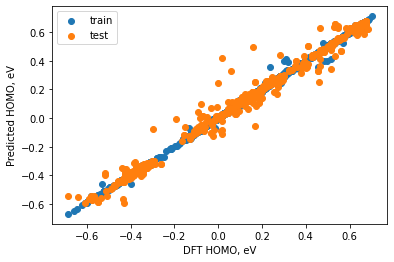

In [15]:
train.loc[:, 'predicted'] = model.predict_structures(train.defect_representation)
test.loc[:, 'predicted'] = model.predict_structures(test.defect_representation)
fig, ax = plt.subplots()
ax.scatter(train.homo, train.predicted, label="train")
ax.scatter(test.homo, test.predicted, label="test")
ax.set_xlabel("DFT HOMO, eV")
ax.set_ylabel("Predicted HOMO, eV")
ax.legend();